In [1]:

%pprint

Pretty printing has been turned OFF



---
# Load needed libraries and functions

In [2]:

%matplotlib inline
from datetime import datetime
from neo4j.exceptions import ServiceUnavailable
import humanize
import os
import sys
import time
import warnings
import winsound

warnings.filterwarnings('ignore')
duration = 1000  # milliseconds
freq = 880  # Hz

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [3]:

t0 = t1 = time.time()

# Get the Storage object
from storage import Storage
s = Storage(
    data_folder_path=os.path.abspath('../data'),
    saves_folder_path=os.path.abspath('../saves')
)

# Get the WebScrapingUtilities object
from scrape_utils import WebScrapingUtilities
wsu = WebScrapingUtilities(
    s=s,
    secrets_json_path=os.path.abspath('../data/secrets/jh_secrets.json')
)
uri = wsu.secrets_json['neo4j']['connect_url']
user =  wsu.secrets_json['neo4j']['username']
password = wsu.secrets_json['neo4j']['password']

# Get the HeaderAnalysis object
from ha_utils import HeaderAnalysis
ha = HeaderAnalysis(s=s, verbose=False)

# Get the CypherUtilities object and Neo4j driver
from cypher_utils import CypherUtilities
cu = CypherUtilities(
    uri=uri, user=user, password=password, driver=None, s=s, ha=ha
)

try:
    version_str = cu.driver.get_server_info().agent
    print(f'======== {version_str} ========')
except ServiceUnavailable as e:
    print(f'You need to start Neo4j as a console')
    raise
except Exception as e:
    print(f'{e.__class__}: {str(e).strip()}')

# Get the IsHeaderSgdClassifier object
from is_header_sgd_classifier import IsHeaderSgdClassifier
ihu = IsHeaderSgdClassifier(ha=ha, cu=cu, verbose=False)

# Get the HeaderCategories object
from hc_utils import HeaderCategories
hc = HeaderCategories(cu=cu, verbose=False)

# Get the LrUtilities object
from lr_utils import LrUtilities
lru = LrUtilities(ha=ha, cu=cu, hc=hc, verbose=False)

# Get the SectionLRClassifierUtilities object
from section_classifier_utils import SectionLRClassifierUtilities
slrcu = SectionLRClassifierUtilities(ha=ha, cu=cu, verbose=False)

# Get the SectionSGDClassifierUtilities object
from section_classifier_utils import SectionSGDClassifierUtilities
ssgdcu = SectionSGDClassifierUtilities(ha=ha, cu=cu, verbose=False)

# Get the SectionCRFClassifierUtilities object
from section_classifier_utils import SectionCRFClassifierUtilities
scrfcu = SectionCRFClassifierUtilities(cu=cu, ha=ha, verbose=False)

# Get the CrfUtilities object
from crf_utils import CrfUtilities
crf = CrfUtilities(
    ha=ha, hc=hc, cu=cu, lru=lru, slrcu=slrcu, scrfcu=scrfcu, ssgdcu=ssgdcu, verbose=True
)

# Get the SectionUtilities object
from section_utils import SectionUtilities
su = SectionUtilities(
    wsu=wsu, ihu=ihu, hc=hc, crf=crf, slrcu=slrcu, scrfcu=scrfcu, ssgdcu=ssgdcu, verbose=False
)

duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
winsound.Beep(freq, duration)
print(f'Utility libraries created in {duration_str}')

======== Neo4j/4.4.7 ========
Utility libraries created in 7 seconds


In [4]:

# Check if the slrcu has built its parts-of-speech logistic regression elements
# Parts-of-speech logistic regression elements is normally built in 1 hour, 27 minutes and 21 seconds
t1 = time.time()
if not hasattr(slrcu, 'pos_predict_percent_fit_dict'):
    slrcu.build_pos_logistic_regression_elements(sampling_strategy_limit=None, verbose=True)
if hasattr(slrcu, 'pos_predict_percent_fit_dict'):
    print('predict_single is available')
else:
    print('predict_single is not available')
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Parts-of-speech logistic regression elements built in {duration_str}')

I have 49,102 labeled parts of speech in here
predict_single is available
Parts-of-speech logistic regression elements built in 7 seconds


In [5]:

# Check if the scrfcu has built its parts-of-speech conditional random field elements
# Parts-of-speech CRF elements normally built in 29 minutes and 57 seconds
t1 = time.time()
if not hasattr(scrfcu, 'pos_symbol_crf'):
    scrfcu.build_pos_conditional_random_field_elements(verbose=True)
if hasattr(scrfcu, 'pos_predict_percent_fit_dict'):
    print('predict_single is now available')
else:
    print('predict_single is not available')
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Parts-of-speech conditional random field elements built in {duration_str}')

predict_single is now available
Parts-of-speech conditional random field elements built in 1 second


In [6]:

# Check if the ssgdcu has built its parts-of-speech stochastic gradient decent elements
t1 = time.time()
if not hasattr(ssgdcu, 'pos_predict_percent_fit_dict'):
    ssgdcu.build_pos_stochastic_gradient_descent_elements(sampling_strategy_limit=None, verbose=True)
if hasattr(ssgdcu, 'pos_predict_percent_fit_dict'):
    print('predict_single is now available')
else:
    print('predict_single is not available')
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Parts-of-speech stochastic gradient descent elements built in {duration_str}')

I have 49,102 labeled parts of speech in here
predict_single is now available
Parts-of-speech stochastic gradient descent elements built in 10 seconds


In [7]:

# Check if the crf has built its parts-of-speech classifier
# POS classifier normally trained in 15 hours, 42 minutes and 41 seconds
t1 = time.time()
if not hasattr(crf, 'CRF'):
    crf.build_pos_conditional_random_field_elements(verbose=True)
if hasattr(crf, 'CRF'):
    print('predict_single is now available')
else:
    print('predict_single is not available')
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'POS classifier trained in {duration_str}')

predict_single is now available
POS classifier trained in 0 seconds


In [8]:

# Check if the lru has built its is-qualified classifier
t1 = time.time()
if not (hasattr(lru, 'ISQUALIFIED_LR') and hasattr(lru, 'ISQUALIFIED_CV')):
    lru.build_isqualified_logistic_regression_elements(sampling_strategy_limit=None, verbose=True)
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Is-qualified LR elements built in {duration_str}')

I have 424,879 is-qualified vocabulary tokens in here
Is-qualified LR elements built in 5 seconds


In [9]:

# Train the isheader classifier
t1 = time.time()
ihu.build_pos_stochastic_gradient_descent_elements(verbose=True)
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Is-header classifier trained in {duration_str}')

I have 49,070 hand-labeled header htmls prepared
7 iterations seen during training fit for a total of 49,070 records trained
Is-header classifier trained in 7 seconds


In [10]:

def display_file_in_text_editor(file_name):
    text_editor_path = r"C:\Program Files\Notepad++\notepad++.exe"
    file_path = os.path.join(ha.SAVES_HTML_FOLDER, file_name)
    !"{text_editor_path}" "{os.path.abspath(file_path)}"

In [11]:

winsound.Beep(freq, duration)
print(f'Last run on {datetime.now()}')

Last run on 2023-11-21 15:38:45.676739



---
# Training

In [12]:

# You need to run this again if you changed the
# qualification dictionary below or in another notebook
t1 = time.time()

# Keep the total retraining time to less than two minutes by adjusting the sampling strategy limit
lru.sync_basic_quals_dict(sampling_strategy_limit=None, verbose=False)

lru.retrain_isqualified_classifier(verbose=True)
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Is-qualified classifer retrained in {duration_str}')

I have 13,272 hand-labeled qualification strings in here
I have 440,487 is-qualified vocabulary tokens in here
Is-qualified classifer retrained in 9 seconds



---
# Inference

Minimum-requirements-met percentages estimated in 1 minute and 20 seconds


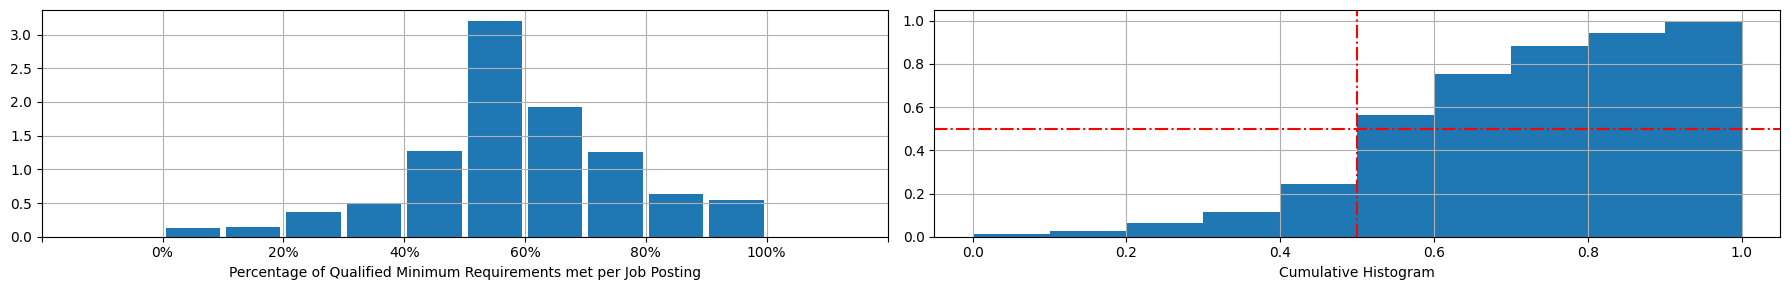

In [13]:

t1 = time.time()

# Loop through all the unset %fit values, set them if you can, break for help if you can't
quals_list, file_name = lru.infer_from_hunting_dataframe(su=su, verbose=False)

# Display as histogram
lru.display_hunting_dataframe_as_histogram()

# Show how long it took
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
winsound.Beep(freq, duration)
print(f'Minimum-requirements-met percentages estimated in {duration_str}')

In [ ]:

# Restarting the kernel and getting to this cell takes 49 seconds, normally
# It takes 1 hour, 45 minutes and 13 seconds of you have to rebuild the LRs
duration_str = humanize.precisedelta(time.time() - t0, minimum_unit='seconds', format='%0.0f')
print(f'Restarting the kernel and getting to this cell took {duration_str}'); raise

In [26]:

# Manually label the unscored qual
qualification_str = quals_list[12]
print(qualification_str); basic_quals_dict = s.load_object('basic_quals_dict')
print(str(basic_quals_dict[qualification_str]) + '\n' if(qualification_str in basic_quals_dict) else '', end='')
basic_quals_dict[qualification_str] = 0
s.store_objects(basic_quals_dict=basic_quals_dict)

Or high school diploma plus a minimum of six (6) years of experience in this field
Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\job-hunting\saves\pkl\basic_quals_dict.pkl



----
## Fix Parts-of-Speech and Quals for this posting

In [ ]:

t1 = time.time()
file_path = os.path.join(cu.SAVES_HTML_FOLDER, file_name)
if os.path.isfile(file_path):
    child_strs_list = ha.get_child_strs_from_file(file_name=file_name)
    cu.ensure_filename(file_name, verbose=False)
    cu.populate_from_child_strings(child_strs_list, file_name, verbose=False)
    print(file_name)
    child_tags_list = ha.get_child_tags_list(child_strs_list)
    feature_dict_list = cu.get_feature_dict_list(child_tags_list, child_strs_list)
    feature_tuple_list = []
    for feature_dict in feature_dict_list:
        feature_tuple_list.append(hc.get_feature_tuple(
            feature_dict, pos_lr_predict_single=slrcu.predict_single, pos_crf_predict_single=scrfcu.predict_single,
            pos_sgd_predict_single=ssgdcu.predict_single
        ))
    crf_list = crf.CRF.predict_single(crf.sent2features(feature_tuple_list))
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'CRF and child strings list recreated in {duration_str}')

In [ ]:

db_pos_list = []
for navigable_parent in child_strs_list:
    db_pos_list = cu.append_parts_of_speech_list(navigable_parent, pos_list=db_pos_list)
pos_list, indices_list = su.visualize_basic_quals_section(crf_list, child_strs_list, db_pos_list=db_pos_list, verbose=True)
winsound.Beep(freq, duration)

In [ ]:
raise

In [ ]:

# Display the context of an individual child string
idx = 13
print(indices_list); child_str = child_strs_list[idx]; pos_symbol = pos_list[idx]; basic_quals_dict = s.load_object('basic_quals_dict')
print(str(basic_quals_dict[child_str]) + '\n' if(child_str in basic_quals_dict) else '', end='')
print(f'{idx} {pos_symbol}) {child_str}')

In [ ]:

# Hand-label this particular child string in the quals dictionary
basic_quals_dict = s.load_object('basic_quals_dict')
basic_quals_dict[child_str] = 1
s.store_objects(basic_quals_dict=basic_quals_dict); print(f'"{child_str}" in basic_quals_dict: {basic_quals_dict[child_str]}')

In [ ]:

def do_cypher_tx(tx, navigable_parent, verbose=False):
    cypher_str = '''
        MATCH (np:NavigableParents {navigable_parent: $navigable_parent})
        SET
            np.is_header = false,
            np.is_task_scope = false,
            np.is_minimum_qualification = true,
            np.is_preferred_qualification = false,
            np.is_educational_requirement = false,
            np.is_legal_notification = false,
            np.is_other = false,
            np.is_corporate_scope = false,
            np.is_job_title = false,
            np.is_office_location = false,
            np.is_job_duration = false,
            np.is_supplemental_pay = false,
            np.is_interview_procedure = false,
            np.is_posting_date = false
        ''' + cu.return_everything_str + ';'
    return [dict(record.items()) for record in tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})]
with cu.driver.session() as session: row_objs_list = session.write_transaction(do_cypher_tx, navigable_parent=child_str, verbose=False)
ihu.retrain_classifier(row_objs_list[0]['navigable_parent'], row_objs_list[0]['is_header'], verbose=False); row_objs_list

In [ ]:

# Show what's in the database already for this html string
def do_cypher_tx(tx, navigable_parent, verbose=False):
    cypher_str = '''
        MATCH (np:NavigableParents {navigable_parent: $navigable_parent})
        ''' + cu.return_everything_str + ';'
    results_list = tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})
    return [dict(record.items()) for record in results_list]
with cu.driver.session() as session: row_objs_list = session.write_transaction(do_cypher_tx, navigable_parent=child_str, verbose=False)
row_objs_list


----
## Maintenance

In [ ]:

# Break up overly-long O-RQs:
# Ensure you have already displayed the context of an individual child string above
# Don't close the Notepad++ window until you have replaced the child string
display_file_in_text_editor(file_name)
cu.rebuild_filename_node(file_name, wsu, navigable_parent=child_str, verbose=False)
winsound.Beep(freq, duration)

In [ ]:

# Remove this particular child string from the quals dictionary and database
basic_quals_dict = s.load_object('basic_quals_dict')
child_str = child_strs_list[idx]
basic_quals_dict.pop(child_str, None)
# basic_quals_dict[child_str] = 0
s.store_objects(basic_quals_dict=basic_quals_dict)
print(f'"{child_str}" in basic_quals_dict: {child_str in basic_quals_dict}')
def do_cypher_tx(tx, qualification_str, verbose=False):
    cypher_str = '''
        MATCH (qs:QualificationStrings {qualification_str: $qualification_str})
        DETACH DELETE qs;
        '''
    results_list = tx.run(query=cypher_str, parameters={'qualification_str': qualification_str})

    return [dict(record.items()) for record in results_list]
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(do_cypher_tx, qualification_str=child_str, verbose=False)

In [ ]:

# Remove file name from database
for file_name in ['']:
    cu.delete_filename_node(file_name, verbose=True)